In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras


print(tf.test.is_gpu_available())
print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

True
2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(housing.data,housing.target,random_state=6)

x_train,x_valid,y_train,y_vaild=train_test_split(x_train_all,y_train_all,random_state=10)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_vaild.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
# 数据标准化

from sklearn.preprocessing import StandardScaler

saclar = StandardScaler()
x_train_sacled = saclar.fit_transform(x_train)
x_valid_sacled = saclar.transform(x_valid)
x_test_sacled=saclar.transform(x_test)

In [7]:

# ※※※※※※※※※※※※※※※※※※※※※※※※※※
# 多输入

# 前5个特征用于wide ,后6个特征用于deep
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])

hidden1 = keras.layers.Dense(30,activation="relu")(input_deep)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)

concat = keras.layers.concatenate([input_wide,hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_wide,input_deep],outputs=[output])


# ※※※※※※※※※※※※※※※※※※※※※※※※※※

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [8]:
# 目标函数：均方差，optimizer：随机梯度下降
model.compile(loss="mean_squared_error",optimizer="sgd")
callbacks=[
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
#     keras.callbacks.ReduceLROnPlateau(patience=2)  # 当指标停止提升时，降低学习速率。
]



In [9]:
# ※※※※※※※※※※※※※※※※※※※※※※※※※※
# 按照前5特征输入wide，后6个特征输入deep
# 来划分数据

x_train_scaled_wide = x_train_sacled[:, :5]
x_train_scaled_deep = x_train_sacled[:,-6:]

x_valid_scaled_wide = x_valid_sacled[:, :5]
x_valid_scaled_deep = x_valid_sacled[:,-6:]

x_test_scaled_wide = x_test_sacled[:, :5]
x_test_scaled_deep = x_test_sacled[:,-6:]



history = model.fit([x_train_scaled_wide,x_train_scaled_deep],y_train,validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],y_vaild),epochs=100,callbacks=callbacks)

# ※※※※※※※※※※※※※※※※※※※※※※※※※※

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 159us/sample - loss: 0.8205 - val_loss: 1.1865
Epoch 2/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.6343 - val_loss: 0.7336
Epoch 3/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.5707 - val_loss: 0.4787
Epoch 4/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4990 - val_loss: 0.4616
Epoch 5/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4371 - val_loss: 0.4505
Epoch 6/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4982 - val_loss: 0.5223
Epoch 7/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4846 - val_loss: 0.4611
Epoch 8/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.6454 - val_loss: 0.4578
Epoch 9/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.45

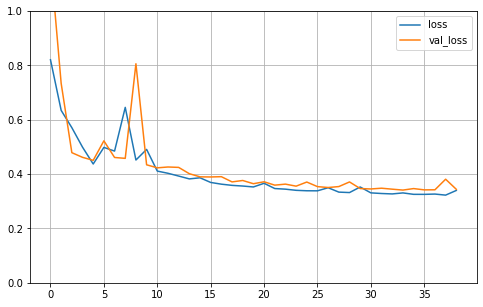

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
# ※※※※※※※※※※※※※※※※※※※※※※※※※※
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],y_test)
# ※※※※※※※※※※※※※※※※※※※※※※※※※※

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.34301032169844753

In [12]:
a=[1,2,4]

In [13]:
a[:-1]

[1, 2]

In [14]:
a[-2:]

[2, 4]